## Restaurants RFM

In [1]:
import pandas as pd
import numpy as np
import nepali_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')
sns.set_palette('pastel')

In [2]:
df = pd.read_csv('barmandoo_invoices.csv')

#### Checking how many null value exists

In [3]:
df.isnull().sum()

id                  0
invoice_number      0
customer_name     397
customer_id         0
total               0
np_date             0
order_id            0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31537 entries, 0 to 31536
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              31537 non-null  int64  
 1   invoice_number  31537 non-null  object 
 2   customer_name   31140 non-null  object 
 3   customer_id     31537 non-null  int64  
 4   total           31537 non-null  float64
 5   np_date         31537 non-null  object 
 6   order_id        31537 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 1.7+ MB


#### Dropping any other columns not required for RFM

In [5]:
df.drop(columns=['id','invoice_number'],inplace=True)

#### Checking any duplicated column

In [6]:
duplicates = df.duplicated()
print('duplicates: ',duplicates.sum())
df.drop_duplicates(inplace=True)


duplicates:  1


In [7]:
print('Duplicates:',df.duplicated().sum())

Duplicates: 0


#### Converting bs date into datetime object

In [8]:
def parse_bs(str_date):
    parts = [int(p) for p in str_date.split('/')]
    bs_date = nepali_datetime.date(parts[0], parts[1], parts[2])
    return bs_date
   

df['np_date'] = df['np_date'].apply(parse_bs) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31536 entries, 0 to 31536
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_name  31139 non-null  object 
 1   customer_id    31536 non-null  int64  
 2   total          31536 non-null  float64
 3   np_date        31536 non-null  object 
 4   order_id       31536 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.4+ MB


#### Top 5 days of most and least sales

In [10]:
item_counts = df['np_date'].value_counts().sort_values(ascending=False)

print("\n Most sold date ")
print(item_counts.head(5).to_string())

print("\n Least sold date ")
print(item_counts.tail(5).to_string())


 Most sold date 
np_date
2081-01-01    116
2080-07-29    115
2080-12-30    107
2080-07-27    101
2080-07-28     99

 Least sold date 
np_date
2079-03-18    10
2080-02-30     8
2079-03-03     6
2081-01-13     5
2081-01-23     1


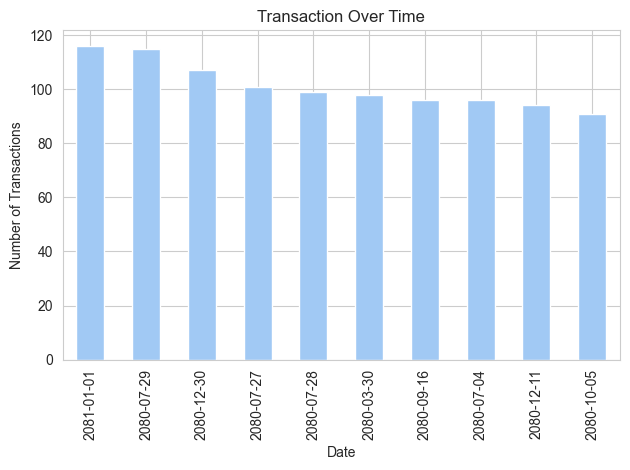

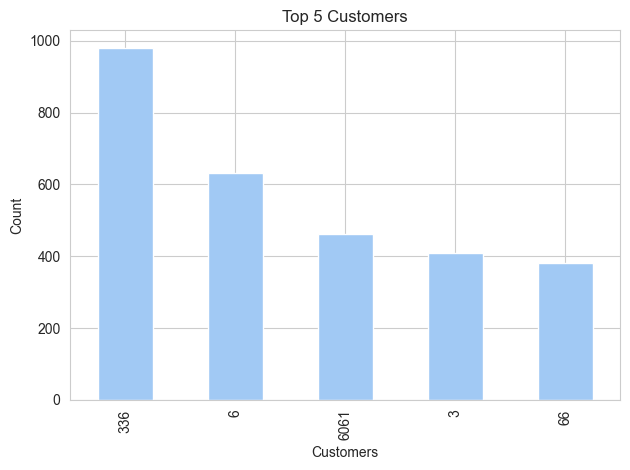

In [11]:
df['np_date'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Transaction Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

df['customer_id'].value_counts().sort_values(ascending=False).head(5).plot(kind='bar')
plt.title('Top 5 Customers')
plt.xlabel('Customers')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Fetching the most recent date and then aggregating RMF values

In [23]:
import datetime

maxDate = df['np_date'].max() + datetime.timedelta(days=1)

rfmData = df.groupby(['customer_id']).agg({
    # 'customer_name':'first',  # keep for reference
    'np_date': lambda x: (maxDate - x.max()).days,
    'order_id': 'count',
    'total': 'sum'
})

# Rename columns
rfmData.rename(columns={
    # 'customer_name': 'Name',
    'np_date': 'Recency',
    'order_id': 'Frequency',
    'total': 'Monetary'
}, inplace=True)

print(rfmData.head())


             Recency  Frequency   Monetary
customer_id                               
1                  1        338  314959.45
2                196         61   29950.40
3                 20        408  253766.95
4                 20        322  513127.61
5                147          3    3023.20


#### Ranking each RFM values

In [24]:
rfm = rfmData.copy()

rfm['R_rank'] = pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1])

data_adjusted = rfm['Frequency'] + np.random.rand(len(rfm)) * 0.001 
rfm['F_rank'] = pd.qcut(data_adjusted,5,labels=[1,2,3,4,5])

rfm['M_rank'] = pd.qcut(rfm['Monetary'],5,labels=[1,2,3,4,5])

print(rfm.head(10).to_string())

             Recency  Frequency   Monetary R_rank F_rank M_rank
customer_id                                                    
1                  1        338  314959.45      5      5      5
2                196         61   29950.40      3      5      5
3                 20        408  253766.95      5      5      5
4                 20        322  513127.61      5      5      5
5                147          3    3023.20      4      4      4
6                 12        633  339082.30      5      5      5
7                135          5    6110.00      4      5      5
8                556          3    3820.00      1      4      4
9                643          5    5790.00      1      5      5
10               288          8   14760.00      3      5      5


#### Grouping customers into differnt segments accouring to RFM ranks

In [25]:
def rfm_segment(row):
    if row['R_rank'] >= 4 and row['F_rank'] >= 4 and row['M_rank'] >= 4:
        return 'Best Customers'
    elif row['F_rank'] >= 4:
        return 'Loyal Customers'
    elif row['M_rank'] >= 4 and row['R_rank'] <= 2:
        return 'At Risk'
    elif row['R_rank'] >= 4 and row['F_rank'] >= 2:
        return 'Potential Loyalists'
    elif row['R_rank'] == 5 and row['F_rank'] == 1:
        return 'New Customers'
    elif row['R_rank'] == 3 and row['F_rank'] >= 2:
        return 'Need Attention'
    elif row['R_rank'] <= 2 and row['F_rank'] <= 2 and row['M_rank'] <= 2:
        return 'Hibernating'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

print(rfm.head().to_string())

             Recency  Frequency   Monetary R_rank F_rank M_rank          Segment
customer_id                                                                     
1                  1        338  314959.45      5      5      5   Best Customers
2                196         61   29950.40      3      5      5  Loyal Customers
3                 20        408  253766.95      5      5      5   Best Customers
4                 20        322  513127.61      5      5      5   Best Customers
5                147          3    3023.20      4      4      4   Best Customers


#### Sorting customers based on total RFM value

In [26]:
rfm['RFM_Score'] = rfm['R_rank'].astype(int) + rfm['F_rank'].astype(int) + rfm['M_rank'].astype(int)
sorted_rfm = rfm.sort_values(by='RFM_Score', ascending=False)
print(sorted_rfm.head().to_string())

             Recency  Frequency   Monetary R_rank F_rank M_rank         Segment  RFM_Score
customer_id                                                                               
9947              19          3    8225.00      5      5      5  Best Customers         15
1                  1        338  314959.45      5      5      5  Best Customers         15
9934              20          5   29190.00      5      5      5  Best Customers         15
43                19        156  143410.00      5      5      5  Best Customers         15
6                 12        633  339082.30      5      5      5  Best Customers         15


#### plotting segmentes according to the rfm values

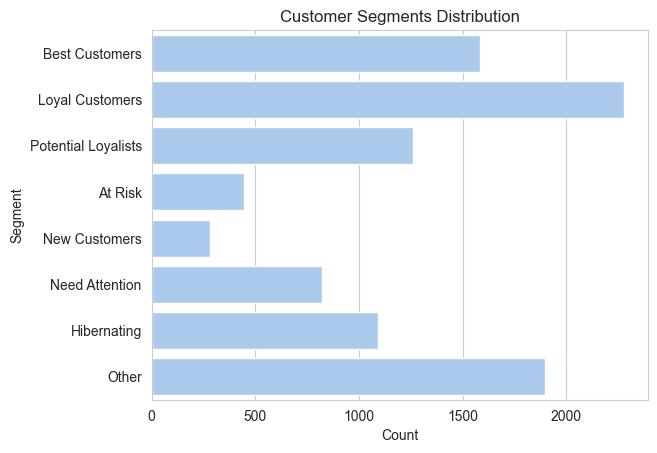

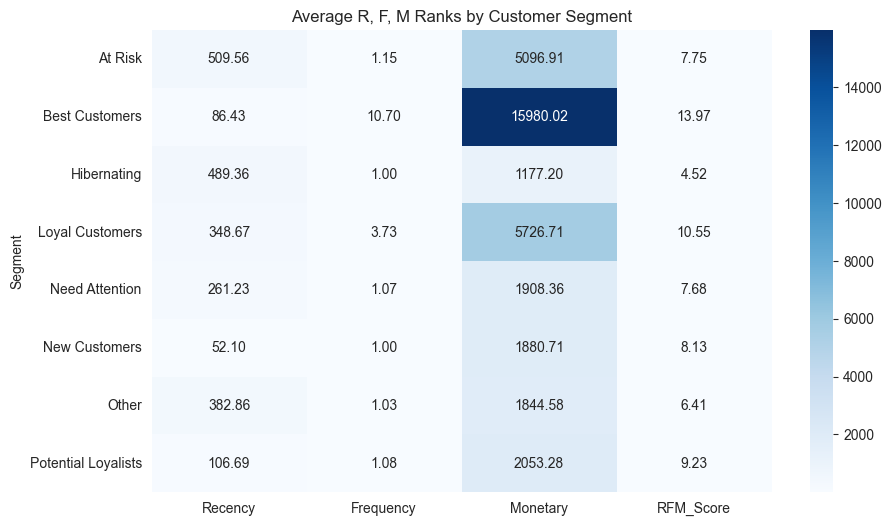

In [27]:
sns.countplot(y='Segment', data=rfm, order=['Best Customers','Loyal Customers', 'Potential Loyalists', 'At Risk', 'New Customers','Need Attention', 'Hibernating','Other'])
plt.title('Customer Segments Distribution')
plt.xlabel('Count')
plt.ylabel('Segment')
plt.show()

pivot = rfm.groupby('Segment').mean(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='Blues', fmt='.2f')
plt.title('Average R, F, M Ranks by Customer Segment')
plt.show()

           Recency    Frequency      Monetary
count  9656.000000  9656.000000  9.656000e+03
mean    288.076222     3.265949  5.189150e+03
std     192.175725    16.144316  2.360046e+04
min       1.000000     1.000000  0.000000e+00
25%     122.000000     1.000000  1.350000e+03
50%     261.000000     1.000000  2.290000e+03
75%     444.000000     2.000000  4.601250e+03
max     688.000000   980.000000  1.879351e+06


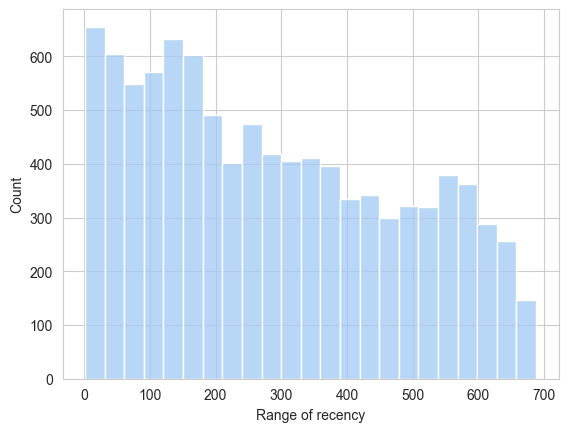

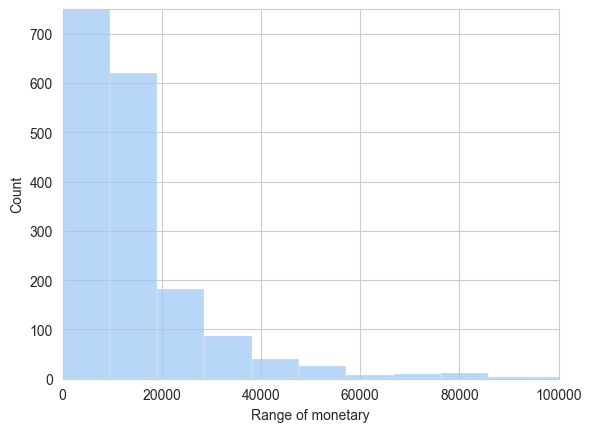

980
1
Frequency
1      5508
2      1796
3       750
4       423
5       256
       ... 
73        1
463       1
108       1
58        1
107       1
Name: count, Length: 80, dtype: int64
count    9656.000000
mean        3.265949
std        16.144316
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       980.000000
Name: Frequency, dtype: float64


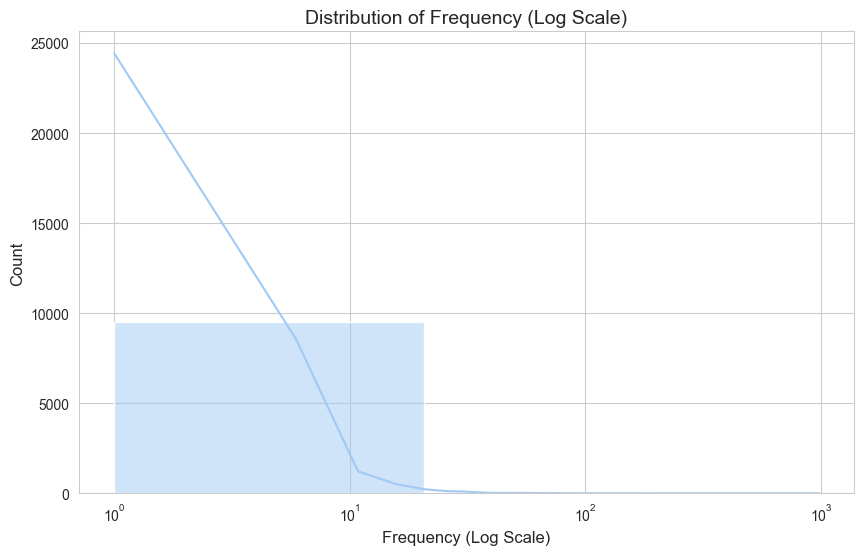

In [28]:
print(rfmData.describe())

sns.histplot(rfmData['Recency'])
plt.xlabel('Range of recency')
plt.ylabel('Count')
plt.show()

sns.histplot(rfmData['Monetary'])
plt.xlabel('Range of monetary')
plt.ylabel('Count')
plt.xlim(0,100000)
plt.ylim(0,750)
plt.show()

print(rfmData['Frequency'].max())
print(rfmData['Frequency'].min())
print(rfmData['Frequency'].value_counts())
print(rfmData['Frequency'].describe())
# sns.histplot(rfmData['Frequency'])
# plt.xlim(1,980)
# plt.ylim(500,2500)
# plt.xlabel('Range of frequency')
# plt.ylabel('Count')
# plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=rfm, x='Frequency', bins=50, kde=True)
plt.xscale('log')

plt.title('Distribution of Frequency (Log Scale)', fontsize=14)
plt.xlabel('Frequency (Log Scale)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [51]:
 rfmData.to_csv('rfm.csv')